# Part 1 | Augmented Reality

## Importing Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

from util.loadVid  import loadVid

In [2]:
import sys
sys.path.append('..')
from common import *

## Constants

In [3]:
OUT = 'out'
if not os.path.exists(OUT):
    os.makedirs(OUT)
    
IN = 'assets'

## Reading the cover image

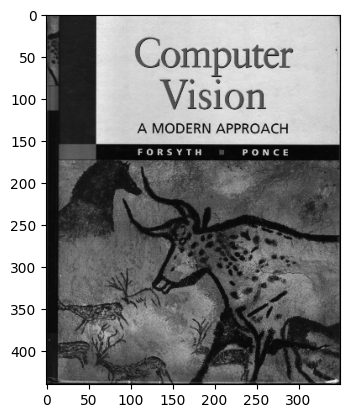

In [4]:
cover = cv2.imread(IN + '/cv_cover.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(cover, cmap='gray')

## Reading the videos

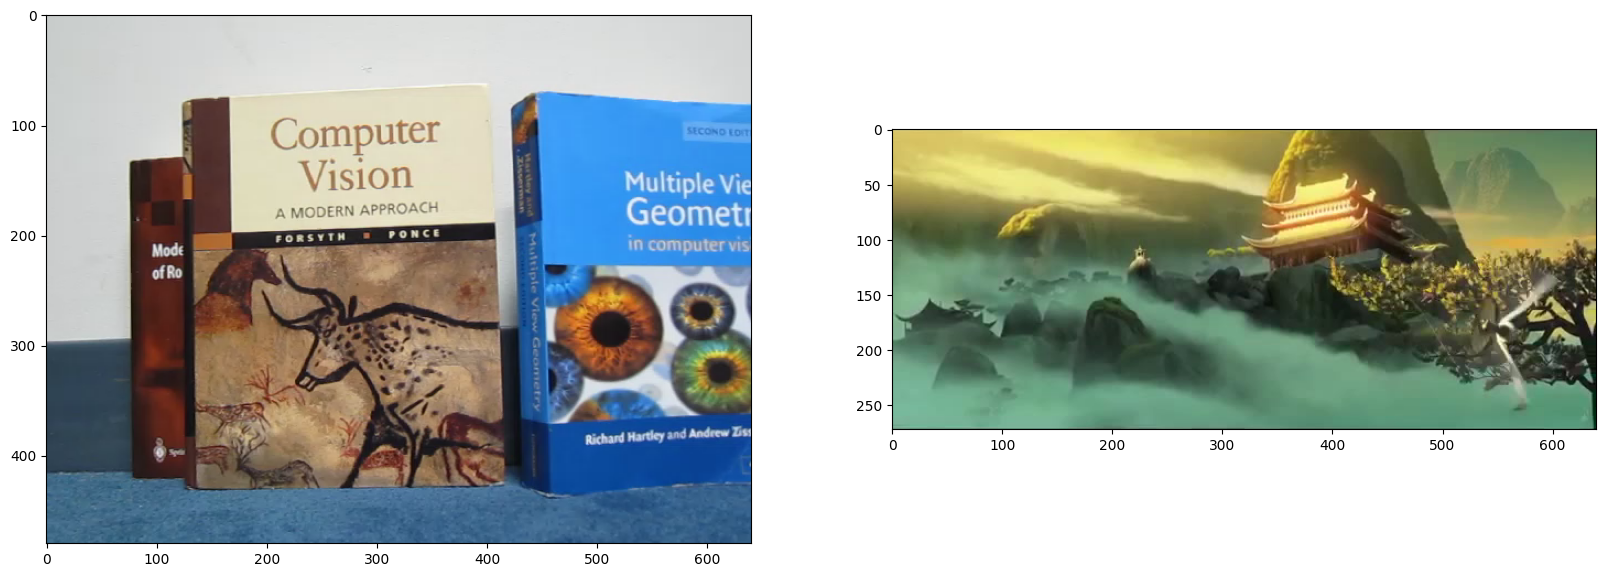

In [5]:
# book_frames = loadVid('assets/book.mov')
# trailer_frames = loadVid(IN + '/ar_source.mov')

# save the captured videos to save time

# np.save(OUT + '/book_frames.npy', book_frames)
# np.save(OUT + '/trailer_frames.npy', trailer_frames)

# load the saved videos

book_frames = np.load(OUT + '/book_frames.npy')

# load trailer and remove black broders
trailer_frames = np.load(OUT + '/trailer_frames.npy')[:,44:-44,:]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(book_frames[0,:,:,::-1])
axes[1].imshow(trailer_frames[0,:,:,::-1])	

## Get dimensions

In [6]:
# book video dimensions
book_h, book_w = book_frames[0].shape[:2]

# trailer video dimensions
trailer_h, trailer_w = trailer_frames[0].shape[:2]

# Cover image dimensions
cover_h, cover_w = cover.shape[:2]

## Calculating the homography matrix

### For the first frame

In [7]:
book_gray = cv2.cvtColor(book_frames[0], cv2.COLOR_BGR2GRAY)

# Calculate descriptors (feature vectors)
kp_cover, des_cover = get_image_sift_feature(cover)
kp_book, des_book = get_image_sift_feature(book_gray)

# Match the features
matches = get_matches(des_cover, des_book)    

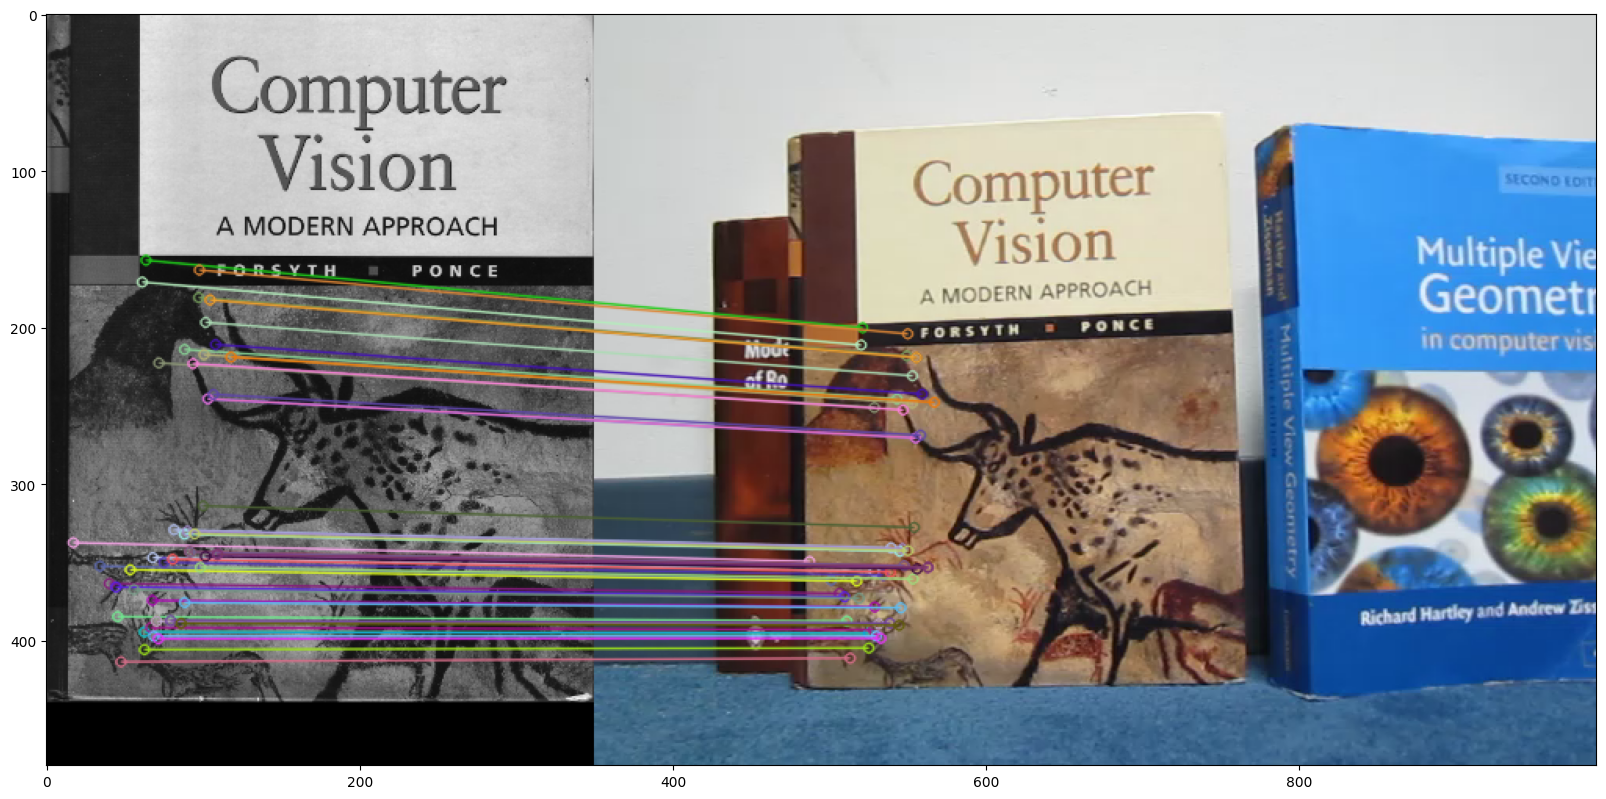

In [8]:
# draw first 50 matches
matched_img = cv2.drawMatchesKnn(cover, kp_cover, book_frames[0], kp_book, matches[:50], book_frames[0].copy(), flags=2)

plt.figure(figsize=(20, 20))
plt.imshow(matched_img[:,:,::-1])
plt.show()

In [9]:
# Get the matched keypoints
pts_cover = get_matched_pt(kp_cover, matches)
pts_book = get_matched_pt(kp_book, matches, query=False)

# Find the homography matrix
homography_mat , _= cv2.findHomography(pts_cover, pts_book)
homography = get_homograph_mat(pts_cover, pts_book)

homography_mat, homography

(array([[ 7.81348485e-01,  8.66791948e-03,  1.18226122e+02],
        [-5.42827055e-02,  7.90855916e-01,  7.62741511e+01],
        [-9.18411924e-05, -5.26371807e-05,  1.00000000e+00]]),
 array([[ 7.70758396e-01,  6.30419200e-03,  1.18679370e+02],
        [-6.37385353e-02,  7.82547259e-01,  7.76255784e+01],
        [-1.21908833e-04, -6.41583864e-05,  1.00000000e+00]]))

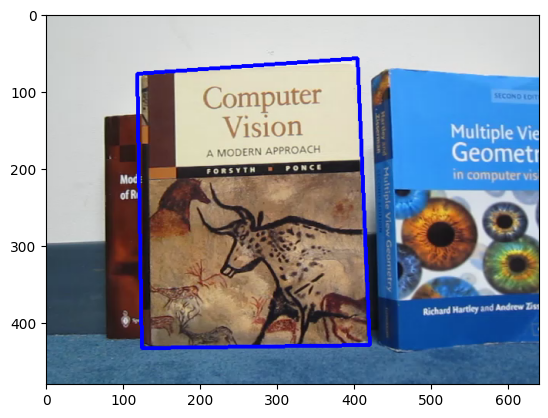

In [10]:
# Get the corners of the cover in the book
corners = np.array([ 
        [0, 0],
        [0, cover_h-1],
        [cover_w-1, cover_h-1],
        [cover_w-1, 0]
    ],
    dtype=np.float32).reshape(-1,1,2)
corners_book = cv2.perspectiveTransform(corners, homography)

# Draw the cover in the book
outline = cv2.polylines(book_frames[0].copy(), [np.int32(corners_book)], True, (255, 0, 0), 3) 

plt.imshow(outline[:,:,::-1])

## Prepare trailer frame

In [11]:
# trailer dimensions wrt cover
# Calculate dimensions
x_min = int(np.min(corners[:,0,0]))
x_max = int(np.max(corners[:,0,0]))
y_min = int(np.min(corners[:,0,1]))
y_max = int(np.max(corners[:,0,1]))

# Calculate the dimensions of the new image
new_w = min(trailer_w,int(x_max - x_min))
new_h = min(trailer_h,int(y_max - y_min))

# center point
center = np.array([trailer_h/2, trailer_w/2])

# trailer corners
x_start = max(0, int(center[0] - new_h/2))
x_end = min(trailer_h, int(center[0] + new_h/2))
y_start = max(0, int(center[1] - new_w/2))
y_end = min(trailer_w, int(center[1] + new_w/2))

cropped_trailer = trailer_frames[0][x_start:x_end, y_start:y_end]
cropped_trailer = cv2.resize(cropped_trailer, (cover_w, cover_h))
cropped_trailer = cv2.warpPerspective(cropped_trailer, homography, (book_w, book_h))

## Overlaying the trailer frame on the book

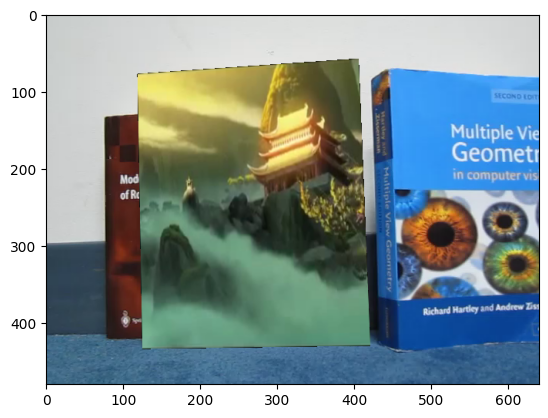

In [12]:
# Create a mask of cover image and create its inverse mask also
cropped_gray = cv2.cvtColor(cropped_trailer, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(cropped_gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

# Black-out the area of cover in book image
book_bg = cv2.bitwise_and(book_frames[0], book_frames[0], mask=mask_inv)

# Put cover in book image and modify the book image
dst = cv2.add(book_bg, cropped_trailer)

plt.imshow(dst[:,:,::-1])

## Combining all the previous steps

In [13]:
from util.prep import *

def generate_video(out_name):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_name, fourcc, 20.0, (book_frames[0].shape[1], book_frames[0].shape[0]))
    _, mask = cv2.threshold(cover, 1, 255, cv2.THRESH_BINARY)

    cover_kp, cover_des = get_image_sift_feature(cover)
    cover_shape = cover.shape[:2]

    for i in range(min(len(book_frames),len(trailer_frames))):
        book = book_frames[i]
        trailer = trailer_frames[i]

        out_current = out_frame(book, cover_kp,cover_des,trailer,cover_shape,mask)
        out.write(out_current)

    out.release()
    cv2.destroyAllWindows()

# generate_video(OUT + '/out.mp4')

In [14]:
# generate_video(OUT + '/out3.mp4')